# BSS: Basketball Statistic System

This system tries to replicate [euRobasketAu](https://github.com/jgalowe/euRobasketAu?organization=jgalowe&organization=jgalowe) R scripts in Python.

It scrapes the data and then converts the raw numbers into _advanced stats_.

The data is provided live by [Genius Sports ](https://developer.geniussports.com/). The documentation for the Basketball feed can be found [here](https://developer.geniussports.com/livestats/tvfeed/index_basketball.html).

Messages are sent in JSON structures and use UTF-8 format.

An example of a raw JSON file:

https://fibalivestats.dcd.shared.geniussports.com/data/2087737/data.json

In [6]:
# Let's first load all required packages...
import json  # https://docs.python.org/3/library/json.html
import os
import pandas as pd
import numpy as np
import datetime
import re

# Load constants
from config import *
import tools

## 1. Build basic PBP dataframe from JSON data

In [10]:
# Load relevant game data
game_id = 742430
game_id = 2087737

game_json = tools.get_json_data(game_id)
pbp_df = tools.get_pbp_df(game_json)

# pbp_df.sample(20)
pbp_df.info()
pbp_df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 566 entries, 563 to 1
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   team_name        566 non-null    object
 1   team_short_name  566 non-null    object
 2   clock            566 non-null    object
 3   s1               566 non-null    int64 
 4   s2               566 non-null    int64 
 5   lead             566 non-null    int64 
 6   tno              566 non-null    int64 
 7   period           566 non-null    int64 
 8   periodType       566 non-null    object
 9   pno              566 non-null    int64 
 10  player           566 non-null    object
 11  success          566 non-null    int64 
 12  actionType       566 non-null    object
 13  actionNumber     566 non-null    int64 
 14  previousAction   566 non-null    object
 15  qualifier        566 non-null    object
 16  subType          566 non-null    object
 17  scoring          566 non-null    in

,team_name,team_short_name,clock,s1,s2,lead,tno,period,periodType,pno,player,success,actionType,actionNumber,previousAction,qualifier,subType,scoring
563,,,00:10:00,0,0,0,0,1,REGULAR,0,,1,jumpball,4,,[],startperiod,0
564,,,00:10:00,0,0,0,0,1,REGULAR,0,,1,period,2,,[],start,0
565,,,00:10:00,0,0,0,0,1,REGULAR,0,,1,game,1,,[],start,0
561,Melbourne United,United,00:09:56,0,0,0,1,1,REGULAR,10,J. Lual-Acuil Jr,1,jumpball,7,4,[],lost,0
562,Tasmania JackJumpers,JackJumpers,00:09:56,0,0,0,2,1,REGULAR,9,F. Krslovic,1,jumpball,6,4,[],won,0
560,Tasmania JackJumpers,JackJumpers,00:09:42,0,0,0,2,1,REGULAR,9,F. Krslovic,0,3pt,9,,[],jumpshot,1
559,Melbourne United,United,00:09:38,0,0,0,1,1,REGULAR,6,J. White,1,rebound,10,9,[],defensive,0
558,Melbourne United,United,00:09:31,0,0,0,1,1,REGULAR,6,J. White,0,3pt,11,,[],jumpshot,1
557,Tasmania JackJumpers,JackJumpers,00:09:27,0,0,0,2,1,REGULAR,9,F. Krslovic,1,rebound,12,11,[],defensive,0
556,Tasmania JackJumpers,JackJumpers,00:09:22,0,0,0,2,1,REGULAR,11,J. Adams,0,3pt,13,,[],pullupjumpshot,1


Check that players' name do not contain the shirt number:

In [7]:
# just check that no player name has a number on it or a comma
pbp_df.loc[pbp_df['player'].str.contains('\d') | pbp_df['player'].str.contains(',')]

,team_name,team_short_name,clock,s1,s2,lead,tno,period,periodType,pno,player,success,actionType,actionNumber,previousAction,qualifier,subType,scoring


In [8]:
pbp_cols = list(pbp_df.columns)
pbp_cols

['team_name',
 'team_short_name',
 'clock',
 's1',
 's2',
 'lead',
 'tno',
 'period',
 'periodType',
 'pno',
 'player',
 'success',
 'actionType',
 'actionNumber',
 'previousAction',
 'qualifier',
 'subType',
 'scoring']

## 2. Extract stints from pbp data

A stint is a lineup that plays in different periods across the game. Starting from the starting lineup, we parse each pbp to build the various stints for each team and the periods each team's stint play across the game.

The stint data is stored in a dictionary:

* key: set of players' names.
* value: list of intervals. 

An interval is tuple `(period no, left datetime.time, right datetime.time)`

In [14]:
# Extract names of teams in the game
team_names = tools.get_team_names(game_json)
team_name_1, team_short_name_1 = team_names[0]
team_name_2, team_short_name_2 = team_names[1]

print(f"Game {team_name_1} ({team_short_name_1}) vs {team_name_2} ({team_short_name_2})")

starters_1 = tools.get_starters(game_json, 1)
starters_2 = tools.get_starters(game_json, 2)
for x in zip([team_name_1, team_name_2], [starters_1, starters_2]):
    print(f"Starters for {x[0]}:")
    print(f"\t {x[1]}")


Game Melbourne United (United) vs Tasmania JackJumpers (JackJumpers)
Starters for Melbourne United:
	 {'J. White', 'M. Dellavedova', 'C. Agada', 'J. Lual-Acuil Jr', 'S. Ili'}
Starters for Tasmania JackJumpers:
	 {'J. Mcveigh', 'J. Adams', 'F. Krslovic', 'J. Magette', 'M. Kenyon'}


Calculate stints data dictionaries for each team:

In [17]:
stints_1 = tools.pbp_stints_extract(pbp_df, starters_1, 1)
stints_2 = tools.pbp_stints_extract(pbp_df, starters_2, 2)

stints_1

{frozenset({'C. Agada',
            'J. Lual-Acuil Jr',
            'J. White',
            'M. Dellavedova',
            'S. Ili'}): [(1, datetime.time(0, 10), datetime.time(0, 5, 53)),
  (2, datetime.time(0, 10), datetime.time(0, 7, 36)),
  (3, datetime.time(0, 10), datetime.time(0, 7, 6)),
  (4, datetime.time(0, 2, 42), datetime.time(0, 1, 20))],
 frozenset({'C. Agada',
            'J. Lual-Acuil Jr',
            'J. White',
            'M. Dellavedova',
            'Y. Baba'}): [(1, datetime.time(0, 5, 53), datetime.time(0, 5, 5)),
  (2, datetime.time(0, 7, 36), datetime.time(0, 4, 46)),
  (3, datetime.time(0, 5, 7), datetime.time(0, 4, 21)),
  (4, datetime.time(0, 7, 28), datetime.time(0, 5, 36))],
 frozenset({'B. Newley',
            'J. Lual-Acuil Jr',
            'J. White',
            'M. Dellavedova',
            'Y. Baba'}): [(1,
   datetime.time(0, 5, 5),
   datetime.time(0, 4, 29))],
 frozenset({'B. Newley',
            'J. Lual-Acuil Jr',
            'M. Peatling',
     

Add colums to pbp dataframe for stint identification:

In [24]:
stints1_df, pbp2_df = tools.pbp_add_stint_col(pbp_df, stints_1, "stint1")
stints2_df, pbp3_df = tools.pbp_add_stint_col(pbp2_df, stints_2, "stint2")

# drop plays that are not for statistics (game events, like start/end)
pbp_stats_df = pbp3_df.loc[(~pbp3_df['actionType'].isin(ACT_NON_STATS))]
pbp_stats_df = pbp_stats_df.loc[(~pbp3_df['subType'].isin(ACTSSUB_NON_STATS))]

pbp_stats_df.head(5)

# should give empty: every row is a play
# pbp_stats_df.loc[pbp_stats_df['stint1'] == -1]

,team_name,team_short_name,clock,s1,s2,lead,tno,period,periodType,pno,player,success,actionType,actionNumber,previousAction,qualifier,subType,scoring,stint1,stint2
561,Melbourne United,United,00:09:56,0,0,0,1,1,REGULAR,10,J. Lual-Acuil Jr,1,jumpball,7,4,[],lost,0,1,1
562,Tasmania JackJumpers,JackJumpers,00:09:56,0,0,0,2,1,REGULAR,9,F. Krslovic,1,jumpball,6,4,[],won,0,1,1
560,Tasmania JackJumpers,JackJumpers,00:09:42,0,0,0,2,1,REGULAR,9,F. Krslovic,0,3pt,9,,[],jumpshot,1,1,1
559,Melbourne United,United,00:09:38,0,0,0,1,1,REGULAR,6,J. White,1,rebound,10,9,[],defensive,0,1,1
558,Melbourne United,United,00:09:31,0,0,0,1,1,REGULAR,6,J. White,0,3pt,11,,[],jumpshot,1,1,1


In [26]:
# An example of a record in the pbp stats dataframe (see stints colums)
pbp_stats_df.loc[4]

team_name          Tasmania JackJumpers
team_short_name             JackJumpers
clock                   00:00:11.600000
s1                                   71
s2                                   76
lead                                 -5
tno                                   2
period                                4
periodType                      REGULAR
pno                                  14
player                      M. McIntosh
success                               1
actionType                      rebound
actionNumber                        769
previousAction                      768
qualifier                            []
subType                       defensive
scoring                               0
stint1                               12
stint2                               19
Name: 4, dtype: object

## 3. Statistics

First, let's extract the plays of the starting lineup for team 1.

In [34]:
# Let's do some stats with the starting team
lineaup = frozenset(starters_1) # we need a hashable
interval = stints_1[lineaup]

df = tools.pbp_get_ranges_df(pbp_stats_df, interval)
df.loc[df['period'] == 4]

/home/ssardina/git/soft/data-science/bball.git/tools.py:249: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return pbp_df[pbp_get_ranges_mask(pbp_df, time_intervals)]


,team_name,team_short_name,clock,s1,s2,lead,tno,period,periodType,pno,player,success,actionType,actionNumber,previousAction,qualifier,subType,scoring,stint1,stint2
57,Tasmania JackJumpers,JackJumpers,00:02:42,64,71,-7,2,4,REGULAR,11,J. Adams,1,freethrow,689,,"[fastbreak, fromturnover]",2of2,1,1,18
58,Tasmania JackJumpers,JackJumpers,00:02:42,64,70,-6,2,4,REGULAR,11,J. Adams,1,freethrow,688,,"[fastbreak, fromturnover]",1of2,1,1,18
59,Tasmania JackJumpers,JackJumpers,00:02:42,64,69,-5,2,4,REGULAR,11,J. Adams,1,foulon,687,686,[],,0,1,18
60,Melbourne United,United,00:02:42,64,69,-5,1,4,REGULAR,16,C. Agada,1,foul,686,,"[shooting, 2freethrow]",personal,0,1,18
54,Melbourne United,United,00:02:24,64,71,-7,1,4,REGULAR,13,M. Dellavedova,0,2pt,695,,[pointsinthepaint],pullupjumpshot,1,1,18
52,Melbourne United,United,00:02:21,64,71,-7,1,4,REGULAR,6,J. White,0,2pt,697,,"[2ndchance, pointsinthepaint]",layup,1,1,18
53,Melbourne United,United,00:02:21,64,71,-7,1,4,REGULAR,6,J. White,1,rebound,696,695,[],offensive,0,1,18
51,Tasmania JackJumpers,JackJumpers,00:02:17,64,71,-7,2,4,REGULAR,14,M. McIntosh,1,rebound,698,697,[],defensive,0,1,18
50,Tasmania JackJumpers,JackJumpers,00:02:04,64,71,-7,2,4,REGULAR,12,J. Magette,0,3pt,699,,[],pullupjumpshot,1,1,18
49,Tasmania JackJumpers,JackJumpers,00:02:01,64,71,-7,2,4,REGULAR,14,M. McIntosh,1,rebound,700,699,[],offensive,0,1,18


Inspect possible actions in a play

In [35]:
# inspect all actions and sub-actions that can be done in a play
actions = tools.pbp_get_actions(pbp_stats_df)
actions

,subType
actionType,
2pt,dunk
2pt,turnaroundjumpshot
2pt,layup
2pt,drivinglayup
2pt,floatingjumpshot
2pt,pullupjumpshot
2pt,hookshot
2pt,stepbackjumpshot
2pt,jumpshot


Let's do a pivot table. Doc:

* https://pandas.pydata.org/docs/user_guide/reshaping.html
* https://nikgrozev.com/2015/07/01/reshaping-in-pandas-pivot-pivot-table-stack-and-unstack-explained-with-pictures/


In [44]:


# pbp_stints_stas_df = pbp_stints_df.loc[pbp_stints_df['tno'].isin(set({1,2})),['team_short_name','actionType', 'subType']]

# pbp_stints_stas_df

# # pbp_stints_stas_df
# pbp3_df = pbp3_df.loc[:, pbp3_df.columns.isin(['team_short_name', 'stint1', 'stint2', 'actionType', 'subType'])]

pivot_stat = pbp_stats_df.pivot_table(
    index=['team_short_name', 'stint1'],
    columns=['actionType', 'subType'],
    values='actionNumber', aggfunc=len, fill_value=0)
# pivot_stat.info()
# pivot_stat.reset_index(inplace=True)

pivot_stat['2pt']



subType                 drivinglayup  dunk  fadeaway  floatingjumpshot  \
team_short_name stint1                                                   
JackJumpers     1                  2     0         0                 0   
                2                  3     0         0                 0   
                3                  0     0         0                 0   
                4                  0     0         0                 0   
                5                  0     0         0                 0   
                6                  0     0         0                 0   
                7                  1     0         0                 0   
                8                  0     0         0                 1   
                9                  0     0         1                 0   
                10                 1     0         0                 0   
                11                 0     0         0                 0   
                12                 1     0         0                 0   
                13                 0     0         0                 0   
                14                 0     0         0                 1   
                15                 0     0         0                 0   
                16                 0     0         0                 0   
                17                 0     0         0                 0   
United          1                  1     1         0                 1   
                2                  1     1         0                 0   
                4                  0     0         0                 0   
                5                  0     0         0                 0   
                6                  0     0         0                 0   
                7                  0     0         0                 0   
                8                  1     0         0                 0   
                9                  0     0         0                 0   
                10                 0     0         0                 1   
                11                 0     0         0                 0   
                12                 1     2         0                 0   
                13                 0     0         0                 0   
                14                 0     0         0                 0   
                15                 1     0         0                 0   
                16                 0     0         0                 0   
                17                 0     0         0                 0   

subType                 hookshot  jumpshot  layup  pullupjumpshot  \
team_short_name stint1                                              
JackJumpers     1              0         2      3               2   
                2              2         1      1               1   
                3              0         0      0               1   
                4              0         0      1               0   
                5              0         0      4               0   
                6              0         0      0               0   
                7              0         0      0               0   
                8              0         0      0               0   
                9              0         0      1               0   
                10             0         0      0               0   
                11             0         0      1               0   
                12             0         0      3               1   
                13             0         0      0               0   
                14             0         0      0               0   
                15             0         0      0               0   
                16             0         0      0               2   
                17             0         0      0               0   
United          1              0         0      6               2   
                2            

In [41]:
pivot_stat2_df = pivot_stat.copy()

# collapse complex columns into a single flat one
pivot_stat2_df.columns = ['_'.join(col) for col in pivot_stat.columns.values]
pivot_stat2_df

2pt_drivinglayup  2pt_dunk  2pt_fadeaway  \
team_short_name stint1                                             
JackJumpers     1                      2         0             0   
                2                      3         0             0   
                3                      0         0             0   
                4                      0         0             0   
                5                      0         0             0   
                6                      0         0             0   
                7                      1         0             0   
                8                      0         0             0   
                9                      0         0             1   
                10                     1         0             0   
                11                     0         0             0   
                12                     1         0             0   
                13                     0         0             0   
                14                     0         0             0   
                15                     0         0             0   
                16                     0         0             0   
                17                     0         0             0   
United          1                      1         1             0   
                2                      1         1             0   
                4                      0         0             0   
                5                      0         0             0   
                6                      0         0             0   
                7                      0         0             0   
                8                      1         0             0   
                9                      0         0             0   
                10                     0         0             0   
                11                     0         0             0   
                12                     1         2             0   
                13                     0         0             0   
                14                     0         0             0   
                15                     1         0             0   
                16                     0         0             0   
                17                     0         0             0   

                        2pt_floatingjumpshot  2pt_hookshot  2pt_jumpshot  \
team_short_name stint1                                                     
JackJumpers     1                          0             0             2   
                2                          0             2             1   
                3                          0             0             0   
                4                          0             0             0   
                5                          0             0             0   
                6                          0             0             0   
                7                          0             0             0   
                8                          1             0             0   
                9                          0             0             0   
                10                         0             0             0   
                11                         0             0             0   
                12                         0             0             0   
                13                         0             0             0   
                14                         1             0             0   
                15                         0             0             0   
                16                         0             0             0   
                17                         0             0             0   
United          1                          1             0             0   
                2                          0             0             0   
                4                          0   

In [30]:

# collapse complex columns into a single flat one
pivot_stat.columns = ['_'.join(col) for col in pivot_stat.columns.values]

pivot_stat.to_csv("stint1_stats.csv", index=False)

In [31]:
# pd.merge(pivot_stat, stints1_df, left_on="stint1", right_on="id", how="left")
pivot_stat.columns

Index(['2pt_drivinglayup', '2pt_dunk', '2pt_fadeaway', '2pt_floatingjumpshot',
       '2pt_hookshot', '2pt_jumpshot', '2pt_layup', '2pt_pullupjumpshot',
       '2pt_stepbackjumpshot', '2pt_turnaroundjumpshot', '3pt_jumpshot',
       '3pt_pullupjumpshot', '3pt_stepbackjumpshot', 'assist_', 'block_',
       'foul_offensive', 'foul_personal', 'foulon_', 'freethrow_1of1',
       'freethrow_1of2', 'freethrow_2of2', 'jumpball_lost', 'jumpball_won',
       'rebound_defensive', 'rebound_offensive', 'rebound_offensivedeadball',
       'steal_', 'timeout_full', 'turnover_badpass', 'turnover_ballhandling',
       'turnover_offensive', 'turnover_outofbounds'],
      dtype='object')

In [148]:
from functools import reduce

def build_stint_stats(pbp_df: pd.DataFrame, col_name: str) -> pd.DataFrame:
    stats_dfs = [pd.DataFrame({col_name : pbp_df[col_name].unique()})]

    # tuples (name, default value, True if attemps/made/per, mask)
    stats = [ ('AST', 0, False, pbp_df['actionType'] == 'assist'),
             # points
            ('2pt_fg', 0, True, pbp_df['actionType'] == '2pt'),
            ('patr', 0, True, pbp_df['subType'].isin(['layup', 'drivinglayup', 'dunk'])),
            ('3pt_fg', 0, True, pbp_df['actionType'] == '3pt'),
            ('ft', 0, True, pbp_df['actionType'] == 'freethrow'),
            # others
            ('rebs', 0, False, pbp_df['actionType'] == 'rebound'),
            ('orebs', 0, False, (pbp_df['actionType'] == 'rebound') & (pbp_df['subType'] == 'offensive')),
            ('drebs', 0, False, (pbp_df['actionType'] == 'rebound') & (pbp_df['subType'] == 'defensive')),
            ('steals', 0, False, pbp_df['actionType'] == 'steal'),
            ('blocks', 0, False, pbp_df['actionType'] == 'block'),
             #turnover types
            ('tovs', 0, False, pbp_df['actionType'] == 'turnover'),
            ('ballhand', 0, False, (pbp_df['actionType'] == 'turnover') &
                                    (pbp_df['subType'].isin(['ballhandling', 'doubledribble', 'travel'])) ),
            ('badpass', 0, False, (pbp_df['actionType'] == 'turnover') & (pbp_df['subType'] == 'badpass') ),
            ('ofoul', 0, False, (pbp_df['actionType'] == 'turnover') & (pbp_df['subType'] == 'offensive') ),
            ('3sec', 0, False, (pbp_df['actionType'] == 'turnover') & (pbp_df['subType'] == '3sec') ),
            ('8sec', 0, False, (pbp_df['actionType'] == 'turnover') & (pbp_df['subType'] == '8sec') ),
            ('24sec', 0, False, (pbp_df['actionType'] == 'turnover') & (pbp_df['subType'] == '24sec') )    
    ]

    for x in stats:
        name, default, rate, mask = x

        name_a = f'{name}a' if rate else name
        name_m = f'{name}m'
        name_p = f'{name}p'

        # record basic stat (attempts when rate)
        df = pbp_df.loc[mask].groupby(col_name).size().reset_index(name=name_a)

        if rate:
            df2 = pbp_df.loc[mask & (pbp_df['success'] == 1)].groupby(col_name).size().reset_index(name=name_m)
            df2.fillna(default, inplace=True)

            df = df.merge(df2, "left")
            df[name_p] = round((df[name_m] / df[name_a])*100, 2)

        df.fillna(default, inplace=True)    #TODO: seems not working, why?
        stats_dfs.append(df)

    # finally, join all df
    df = reduce(lambda df1, df2: df1.merge(df2, "left"), stats_dfs)
    df.fillna(0, inplace=True)

    # now some complex stats from prev columns
    # --------------------------------------------------
    df['pts'] = 2*df['2pt_fgm'] + 3*df['3pt_fgm'] + df['ftm']

    # calculate home possesions (possessions only count change of hands, not offensive rebounds and new shots)
    df['poss'] = df['2pt_fga'] + df['3pt_fga'] + 0.44*df['fta'] + df['tovs'] - df['orebs']
    df.loc[df['poss'] < 0, 'poss'] = 0

    return df

stint1_stats_df = build_stint_stats(pbp_stats_df, 'stint1')
stint1_stats_df
# list(pbp_stats_df['stint1'].unique())


,stint1,AST,2pt_fga,2pt_fgm,2pt_fgp,patra,patrm,patrp,3pt_fga,3pt_fgm,...,blocks,tovs,ballhand,badpass,ofoul,3sec,8sec,24sec,pts,poss
0,1,8.0,22.0,10.0,45.45,13.0,8.0,61.54,14.0,4.0,...,2.0,7.0,3.0,2.0,2.0,0.0,0.0,0.0,34.0,36.76
1,2,2.0,13.0,6.0,46.15,8.0,5.0,62.50,9.0,1.0,...,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,18.0,20.76
2,3,1.0,1.0,1.0,100.00,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.00
3,4,1.0,2.0,2.0,100.00,1.0,1.0,100.00,0.0,0.0,...,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,6.0,4.88
4,5,4.0,4.0,2.0,50.00,4.0,2.0,50.00,4.0,3.0,...,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,16.0,9.32
5,6,0.0,1.0,1.0,100.00,1.0,1.0,100.00,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.88
6,7,0.0,5.0,3.0,60.00,4.0,3.0,75.00,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,6.00
7,8,0.0,2.0,0.0,0.00,1.0,0.0,0.00,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,3.88
8,9,1.0,3.0,2.0,66.67,1.0,1.0,100.00,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,5.76
9,10,2.0,2.0,1.0,50.00,1.0,1.0,100.00,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,4.44


### Ploting

- https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

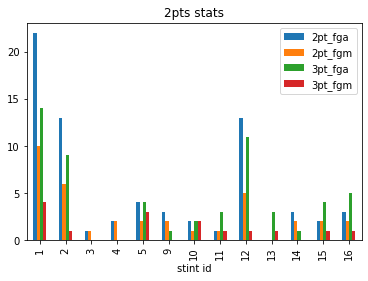

In [119]:
axis_y = ['2pt_fga', "2pt_fgm", '3pt_fga', "3pt_fgm"]
stint1_stats_df.plot(kind="bar", x='stint1', y=axis_y, title="2pts stats", xlabel="stint id")

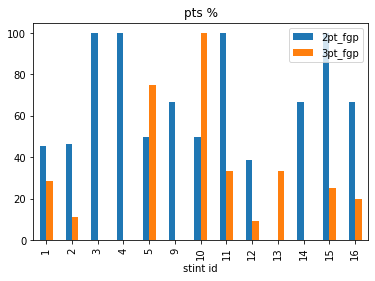

In [120]:
axis_y = ['2pt_fgp', "3pt_fgp"]
stint1_stats_df.plot(kind="bar", x='stint1', y=axis_y, title="pts %", xlabel="stint id")

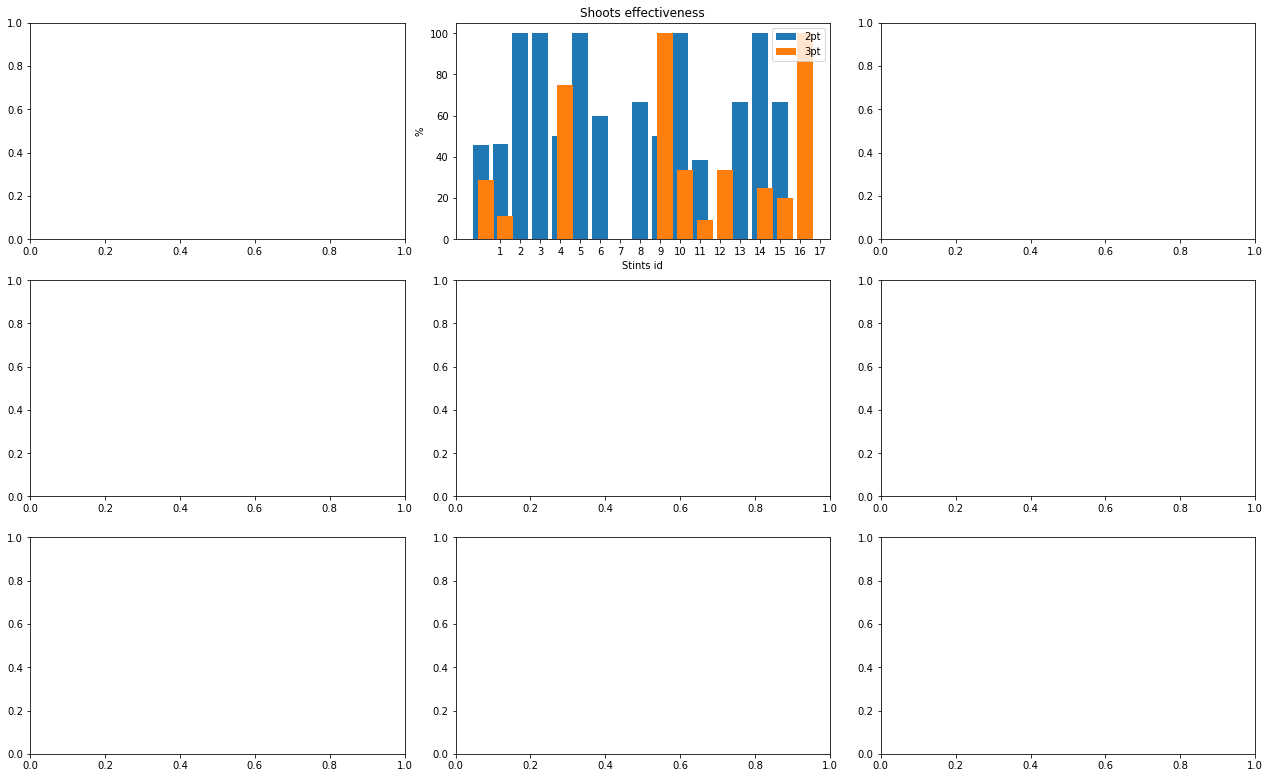

In [169]:
import matplotlib.pyplot as plt
import seaborn as sns

# # Create a list of all column names, except for 'ID'.
stints = list(stint1_stats_df['stint1'])

# numerical x
X = np.arange(len(stints))

# # # Create a 3x5 matrix of subplots and add padding around them for readability.
fig, axes = plt.subplots(3, 3, figsize=(18, 11))
fig.tight_layout(pad=2.0)

ax = plt.subplot(3, 3, 2)
# ax.add_axes([0,0,1,1])
ax.bar(X, stint1_stats_df['2pt_fgp']);
ax.bar(X + 2, stint1_stats_df['3pt_fgp']);
ax.legend(labels=['2pt', '3pt']);
ax.set_ylabel('%');
ax.set_xlabel('Stints id');
ax.set_title("Shoots effectiveness");
ax.set_xticks(stints);

# # Loop over the columns of the DataFrame and create a KDE for each one.
# for i in range(len(cols)):
#     ax = plt.subplot(3, 5, i+1)  # we are using a 3x5 matrix, and this plot is in index i+1 (1 being the top left)
#     ax.hist(stint1_stats_df[cols[i]], density=True, bins=30)
#     ax.set_title(cols[i])  # set its title to the column name
#     sns.kdeplot(ax=ax, data=stint1_stats_df[cols[i]])